# Задача
Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца.

1. Выбрать основную метрику, которую мы планируем прогнозировать. Обосновать, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
2. Построить модель и провалидировать её. Хватает ли у нас данных для бэккастинга с текущей задачей? Если нет, то определить, для какого горизонта прогнозирования у нас хватает данных.
3. Выбрать ту модель, которая кажется вам наиболее удачной. Проинтерпретировать её результаты. Если видите какие-то важные ограничения по выводу – не забудьте их тоже указать.

## Метрика
Для прогноза возьмем метрику DAU , она считает количество уникальных пользователей , как это и отражает нашу проблему. \
Временной промежуток возьмем весь что представлен в нашем датасете с 3 июня. \
Регрессоры в нашей модели использовать не будем. Потому что, чтобы ими воспользоваться нам надо будет предсказывать значения этих регрессоров. Мы хотим сдлеать прогноз на месяц вперед, а у нас есть данные за неполные два месяца. если сначала предсказывать регрессоры, а потом по ним предсказывать DAU, то результат может быть хуже, чем если просто предсказывать DAU.

In [1]:
!pip install orbit-ml

In [2]:
!pip install pandahouse

In [45]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import mae, mse, smape, wmape

import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import arviz as az

In [4]:
# Выгружаем данные по нашей метрике.К этому было бы ещё хорошо добавить активность в плане сообщений

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student',
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT
    a.day,
    a.dau,
    (a.activity + COALESCE(b.actions_mes, 0)) AS total_activity
FROM (SELECT toStartOfDay(toDateTime(date)) AS day,
             unique_users AS dau,
             unique_action AS activity
        FROM (SELECT date(time) AS date,
                     COUNT(DISTINCT user_id) AS unique_users,
                     COUNT(action) AS unique_action
              FROM simulator_20230720.feed_actions
              GROUP BY date) AS t1
        GROUP BY day, dau, activity) AS a
LEFT JOIN ( SELECT toStartOfDay(time) AS day,
                   COUNT(reciever_id) AS actions_mes
            FROM simulator_20230720.message_actions
           GROUP BY day) AS b
ON a.day = b.day
ORDER BY a.day;
'''

activity = ph.read_clickhouse(query=query, connection=connection)
#activity.drop(labels = [99],axis = 0, inplace = True)
activity

,day,dau,total_activity
0,2023-06-03,878,12389
1,2023-06-04,2238,88481
2,2023-06-05,3105,139381
3,2023-06-06,3721,155693
4,2023-06-07,4617,221856
...,...,...,...
94,2023-09-05,19632,725731
95,2023-09-06,19933,877662
96,2023-09-07,19542,882723
97,2023-09-08,19288,794037


In [51]:
#отложим данные для теста
test_data = activity.loc[(activity.day >= "2023-06-03") & (activity.day < "2023-07-04"), :]

In [5]:
print(f"Начало: {activity.day.min().date()} \nКонец: {activity.day.max().date()}")

Начало: 2023-06-03 
Конец: 2023-09-09


In [6]:
#зададим шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

<Axes: xlabel='day', ylabel='dau'>

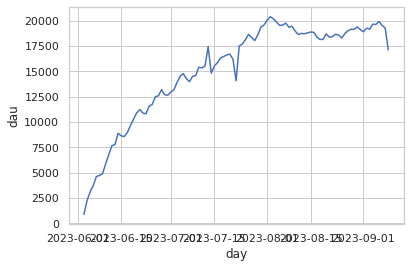

In [7]:
#как менялся DAU
sns.lineplot(x="day", y="dau", data=activity)

<Axes: xlabel='day', ylabel='total_activity'>

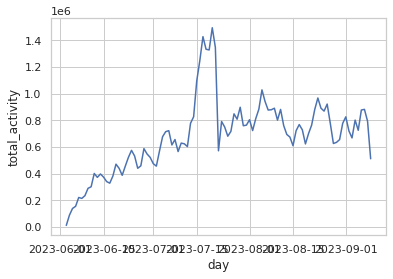

In [8]:
#как менялся аколичество действий
sns.lineplot(x="day", y="total_activity", data=activity)

Отметим ещё бинарным образом промежуток от 2023-07-13 по 2021-07-21. Дни проведение рекламной компании:

In [9]:
activity["anomaly"] = np.where((activity.day >= "2023-07-13") & (activity.day <= "2021-07-21"), 1, 0)
activity.head()

,day,dau,total_activity,anomaly
0,2023-06-03,878,12389,0
1,2023-06-04,2238,88481,0
2,2023-06-05,3105,139381,0
3,2023-06-06,3721,155693,0
4,2023-06-07,4617,221856,0


In [10]:
#Для первичной работы лучше стандартизовать наши модели:
act_mean = activity.total_activity.mean()
act_sd = activity.total_activity.std()

dau_mean = activity.dau.mean()
dau_sd = activity.dau.std()

activity["dau_stand"] = (activity.dau - dau_mean) / dau_sd
activity["act_stand"] = (activity.total_activity - act_mean) / act_sd

In [11]:
activity.head()

,day,dau,total_activity,anomaly,dau_stand,act_stand
0,2023-06-03,878,12389,0,-2.920635,-2.392554
1,2023-06-04,2238,88481,0,-2.642395,-2.120179
2,2023-06-05,3105,139381,0,-2.465017,-1.937979
3,2023-06-06,3721,155693,0,-2.338990,-1.879590
4,2023-06-07,4617,221856,0,-2.155679,-1.642756


## Строим модели

Какие модели у нас будут:

1. Обычная модель с линейным трендом
2. Обычная модель с логлинейным трендом
3. Линейный тренд + DAU как регрессор
4. Логлинейный тренд + DAU как регрессор
5. Линейный тренд + DAU + аномалия
6. Логлинейный тренд + DAU + аномалия

In [12]:
simple_lin = DLT(response_col="act_stand", 
                 date_col="day", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

simple_loglin = DLT(response_col="act_stand", 
                 date_col="day", 
                 estimator="stan-mcmc", 
                 global_trend_option="loglinear",
                 num_warmup=10000,
                 num_sample=10000)

dau_lin = DLT(response_col="act_stand", 
            date_col="day", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["dau_stand"], regressor_sign=["+"], 
            num_warmup=10000,
            num_sample=10000)

dau_loglin = DLT(response_col="act_stand", 
               date_col="day", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["dau_stand"], regressor_sign=["+"], 
               num_warmup=10000,
               num_sample=10000)

anom_lin = DLT(response_col="act_stand", 
            date_col="day", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["dau_stand", "anomaly"], regressor_sign=["+", "+"], 
            num_warmup=10000,
            num_sample=10000)

anom_loglin = DLT(response_col="act_stand", 
               date_col="day", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["dau_stand", "anomaly"], regressor_sign=["+", "+"], 
               num_warmup=10000,
               num_sample=10000)

In [13]:
#положим в список
model_list = [simple_lin, simple_loglin, dau_lin, dau_loglin, anom_lin, anom_loglin]
#обучаем
for model in model_list:
    model.fit(activity)

2023-09-09 16:05:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:05:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:05:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:06:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:06:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:06:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [14]:
#Чтобы оценить предсказания, нам надо сотворить future df для наших моделек. Начнём с первых двух:
futur = model_list[0].make_future_df(periods=30)

In [15]:
pred_1 = model_list[0].predict(futur)
pred_2 = model_list[1].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

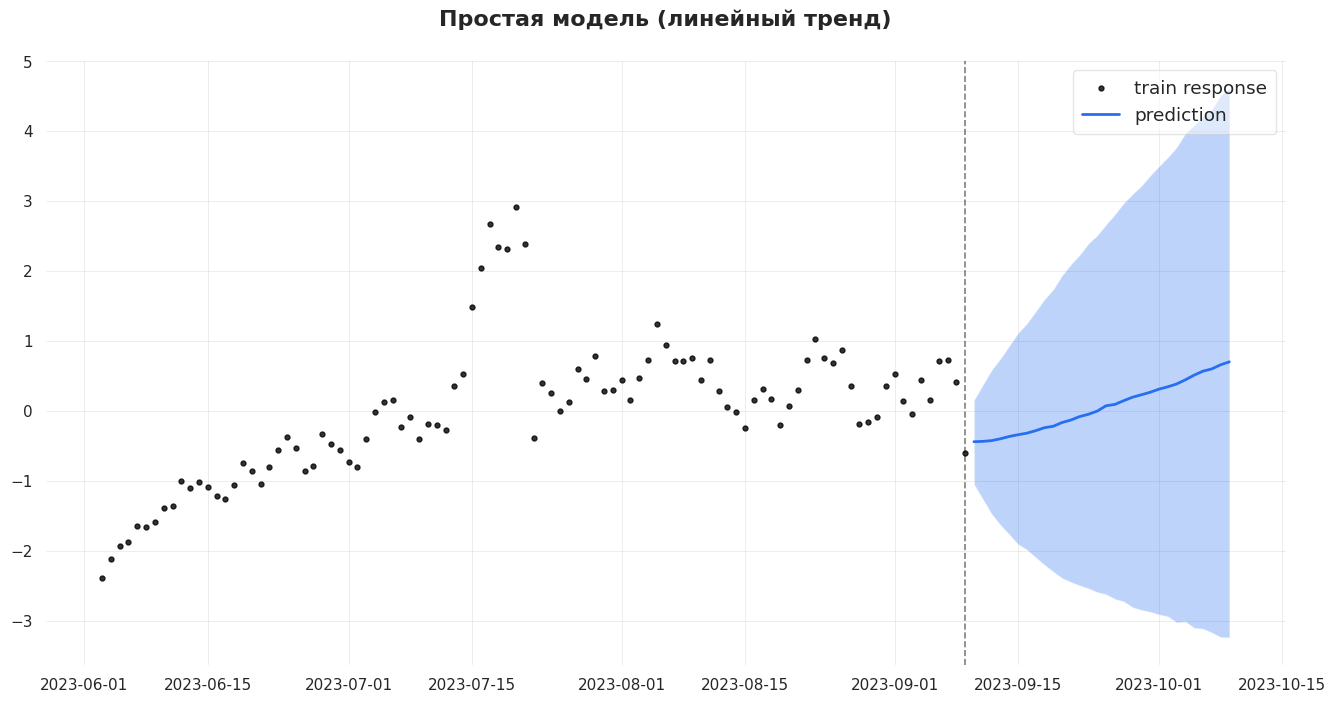

In [16]:
_ = plot_predicted_data(activity, pred_1, "day", 'act_stand', title='Простая модель (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

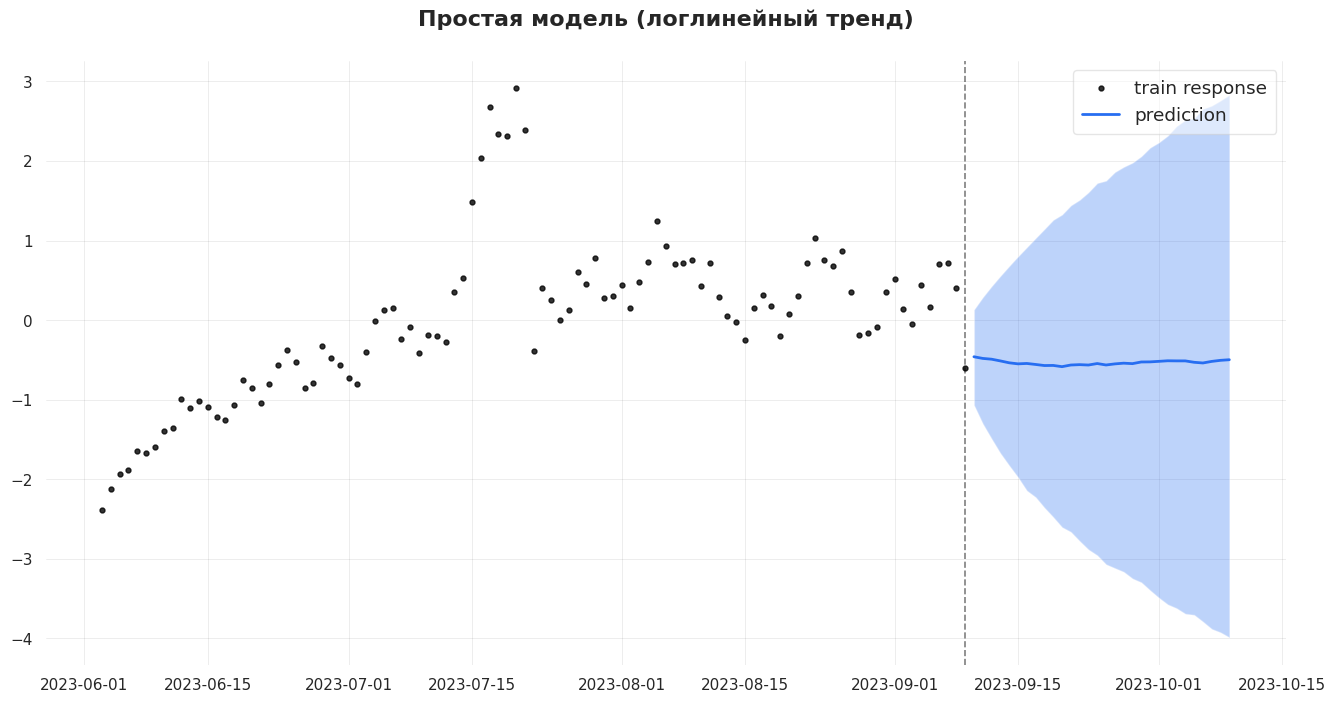

In [17]:
_ = plot_predicted_data(activity, pred_2, "day", 'act_stand', title='Простая модель (логлинейный тренд)')

Для полагающихся на DAU моделей нам нужно дополнить наш df предсказаниями будущего DAU:

In [18]:
dau_model = DLT(response_col="dau_stand", 
                 date_col="day", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

dau_model.fit(activity)
dau_pred = dau_model.predict(futur)

2023-09-09 16:07:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

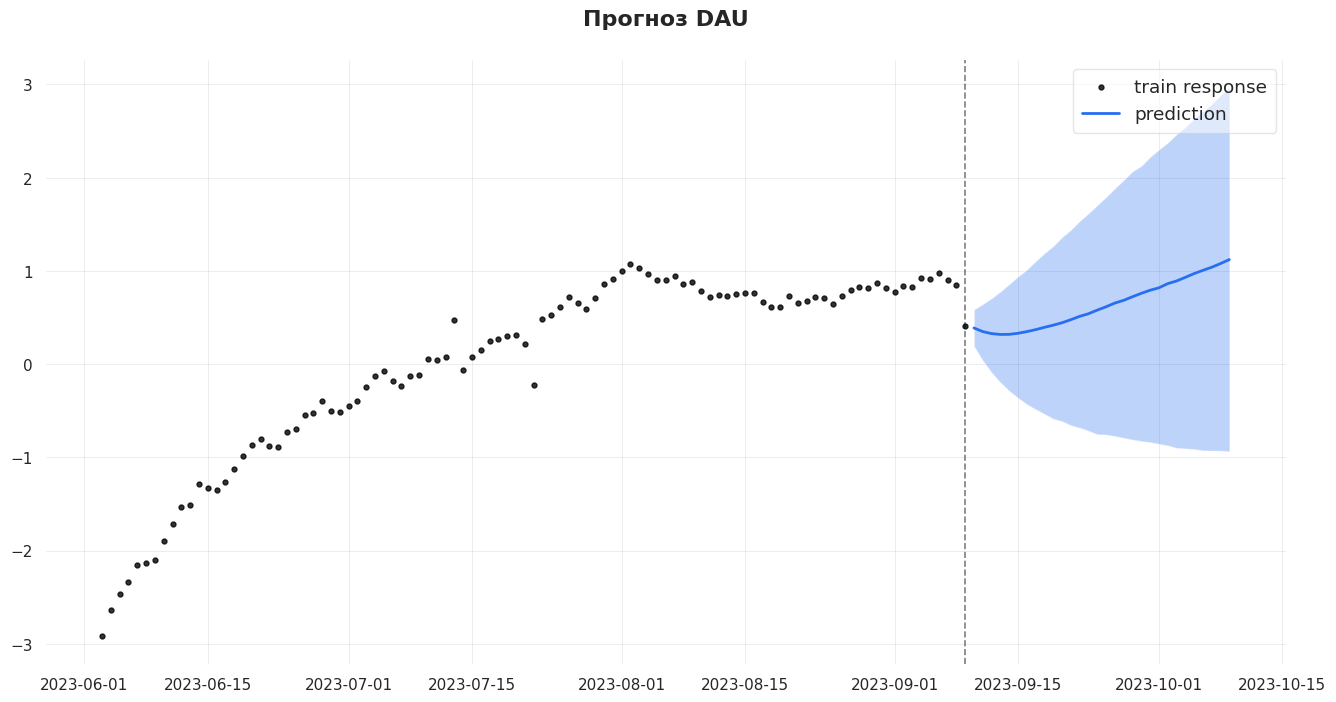

In [19]:
_ = plot_predicted_data(activity, dau_pred, "day", 'dau_stand', title='Прогноз DAU')

In [20]:
#Добавим линейный прогноз в наш будущий df:
futur["dau_stand"] = dau_pred.prediction
futur.head()

,day,dau_stand
0,2023-09-10,0.387387
1,2023-09-11,0.348898
2,2023-09-12,0.327040
3,2023-09-13,0.318022
4,2023-09-14,0.318927


In [21]:
model_list[2].get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,dau_stand,Positive,1.029715,0.568799,1.492054,1.0,0.0


In [22]:
pred_3 = model_list[2].predict(futur)
pred_4 = model_list[3].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

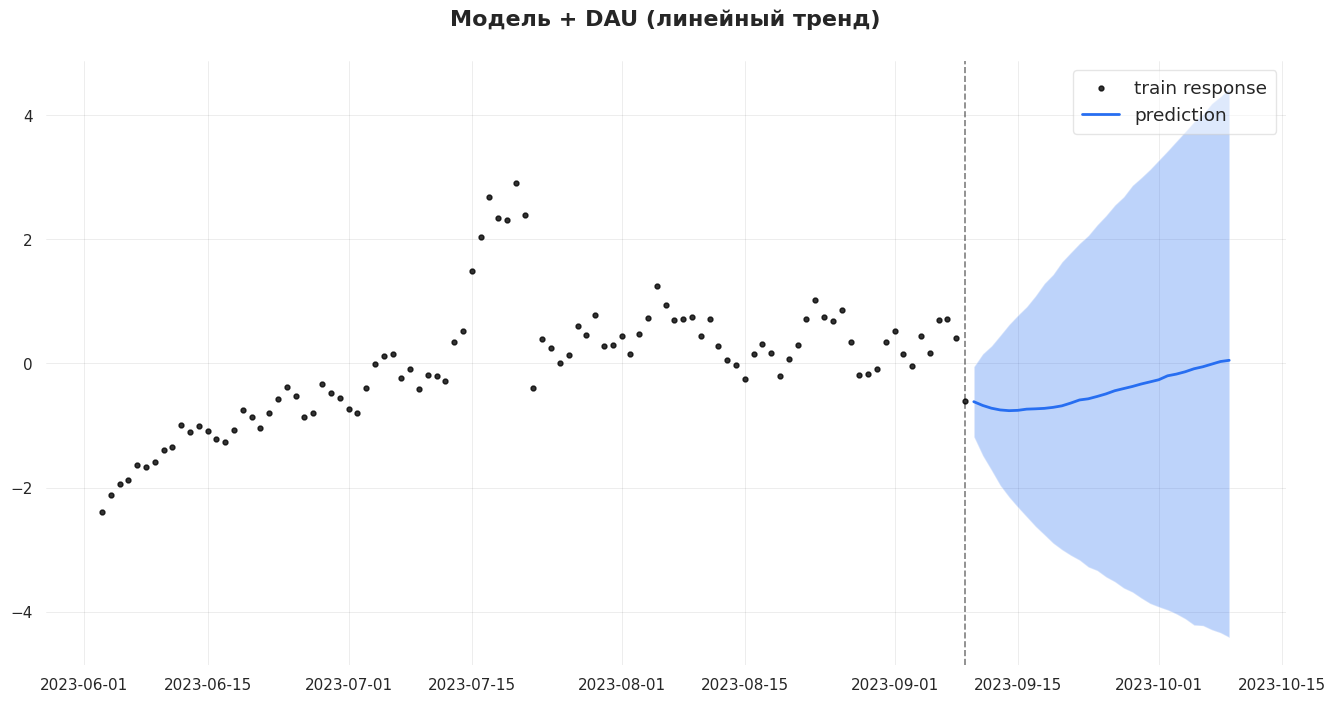

In [23]:
_ = plot_predicted_data(activity, pred_3, "day", 'act_stand', title='Модель + DAU (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

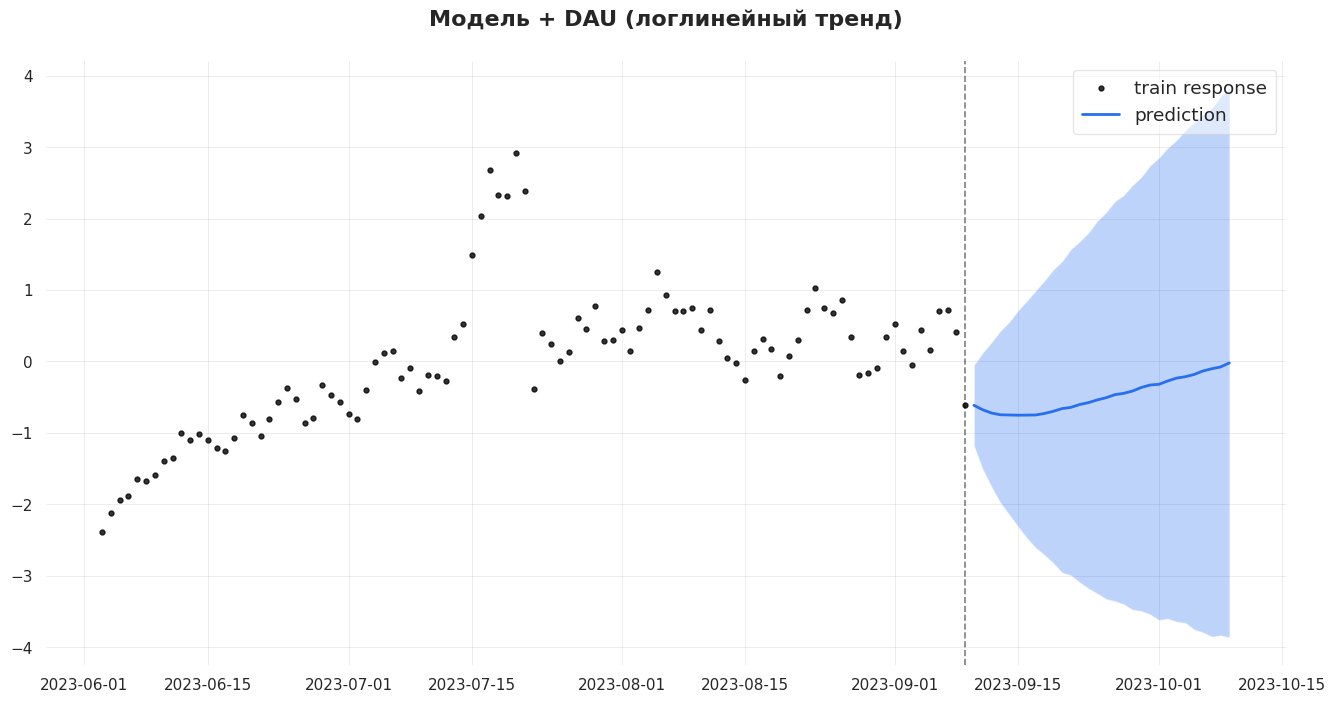

In [24]:
_ = plot_predicted_data(activity, pred_4, "day", 'act_stand', title='Модель + DAU (логлинейный тренд)')

In [25]:
#Наконец, попробуем добавить бинарную переменную:
futur["anomaly"] = 0
futur.head()

,day,dau_stand,anomaly
0,2023-09-10,0.387387,0
1,2023-09-11,0.348898,0
2,2023-09-12,0.327040,0
3,2023-09-13,0.318022,0
4,2023-09-14,0.318927,0


In [26]:
pred_5 = model_list[4].predict(futur)
pred_6 = model_list[5].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

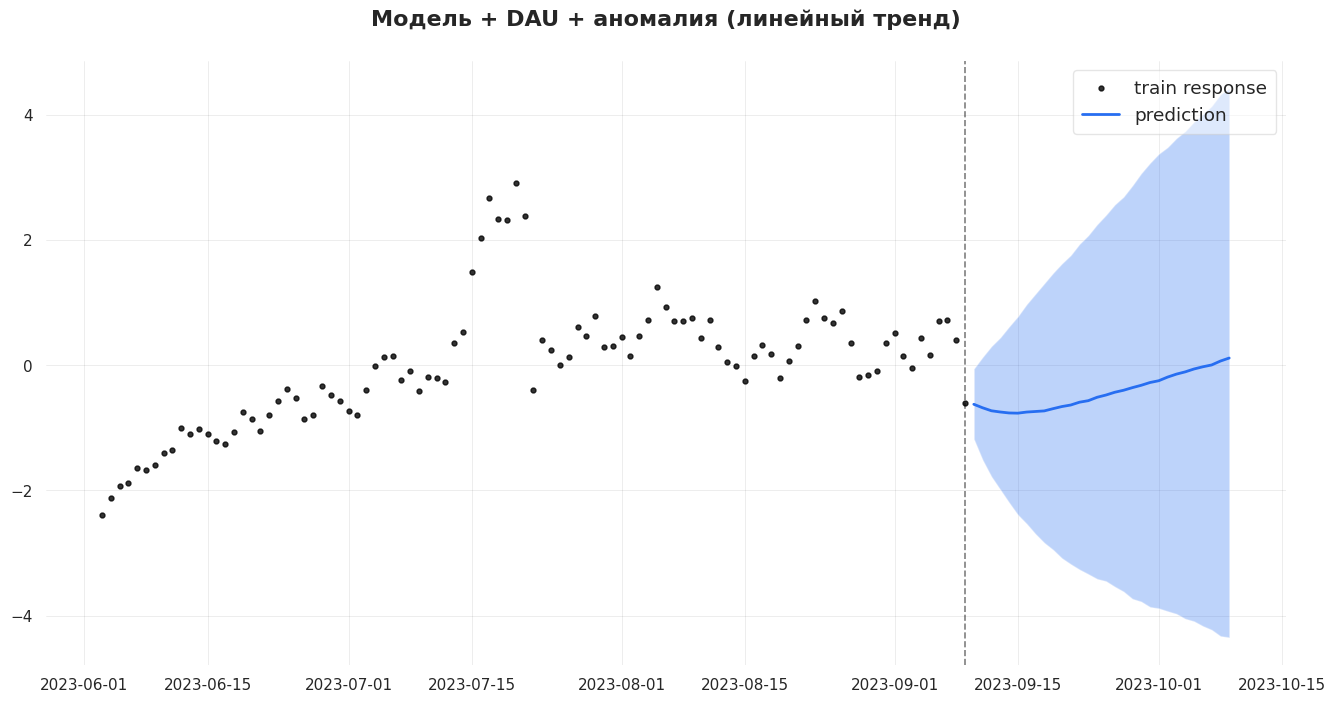

In [27]:
_ = plot_predicted_data(activity, pred_5, "day", 'act_stand', title='Модель + DAU + аномалия (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

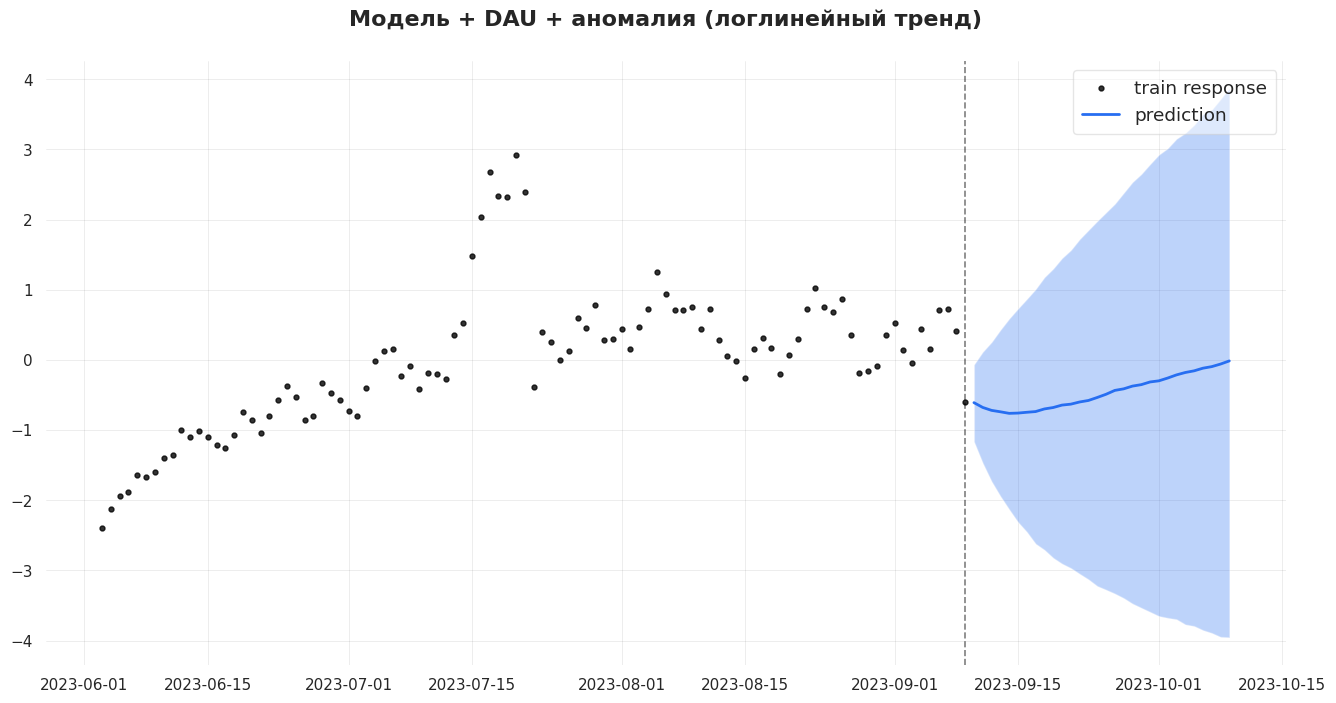

In [28]:
_ = plot_predicted_data(activity, pred_6, "day", 'act_stand', title='Модель + DAU + аномалия (логлинейный тренд)')

## Оцениваем качество

In [29]:
#сделаем список для бэктестеров
#начнём со скользящего
test_list_rolling = []
for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=activity,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
    backtester.fit_predict()
    
    test_list_rolling.append(backtester)

2023-09-09 16:07:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:07:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:08:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:09:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:10:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:11:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [30]:
test_list_exp = []
for model in model_list:
    backtester = BackTester(
    model=model,
    df=activity,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="expanding")
    
    backtester.fit_predict()
    
    test_list_exp.append(backtester)

2023-09-09 16:12:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:12:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:13:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:13:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:13:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:13:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:13:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:14:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:14:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:14:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:14:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:14:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:14:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:14:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:15:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:15:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:15:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:15:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:15:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:15:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:16:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:16:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:16:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:16:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:16:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:16:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:17:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:17:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:17:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:17:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:17:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:18:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:18:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:18:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:18:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:19:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:19:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:19:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:19:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:19:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:19:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:19:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:20:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:20:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:20:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:20:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:21:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:21:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:21:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:21:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:21:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:21:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:22:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:22:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:22:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:22:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:22:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:23:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:23:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:23:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:23:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:24:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:24:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:24:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:24:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:24:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:24:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:25:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:25:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:25:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:25:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:25:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:26:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:26:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [31]:
#Посмотрим, что получилось:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)
    
roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

In [32]:
roll_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,1.057653,False
1,wmape,1.089107,False
1,mape,21.667225,False
1,mse,1.130821,False
1,mae,0.719711,False


In [33]:
for metric in roll_df.metric_name.unique():
    winning_model = roll_df.loc[roll_df.metric_name == metric].metric_values.idxmin()
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 2
Самая лучшая модель по метрике wmape - 2
Самая лучшая модель по метрике mape - 2
Самая лучшая модель по метрике mse - 2
Самая лучшая модель по метрике mae - 2
Самая лучшая модель по метрике rmsse - 2


Итого больше всего склоняется к логлинейной с дополнительной дамми-переменной.
Что по этому поводу скажет WBIC?

In [36]:
for model in model_list:
    model.fit_wbic(activity)

2023-09-09 16:27:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.595, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:27:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.595, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:28:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.595, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:28:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.595, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:28:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.595, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-09 16:29:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.595, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [37]:
for number, model in enumerate(model_list):
    print(f"Модель №{number+1}, WBIC = {model.get_wbic()}")

Модель №1, WBIC = 107.61451725611806
Модель №2, WBIC = 103.54913505832474
Модель №3, WBIC = 96.91443741307187
Модель №4, WBIC = 93.93946578067572
Модель №5, WBIC = 97.28886579511077
Модель №6, WBIC = 93.52855848226922


Таким образом, мы скорее склоняемся к модели №6!

## Дополнительный анализ модели №6

Посмотрим пару дополнительных штук относительно последней модели:

In [39]:
comps = model_list[5].predict(futur, decompose=True)

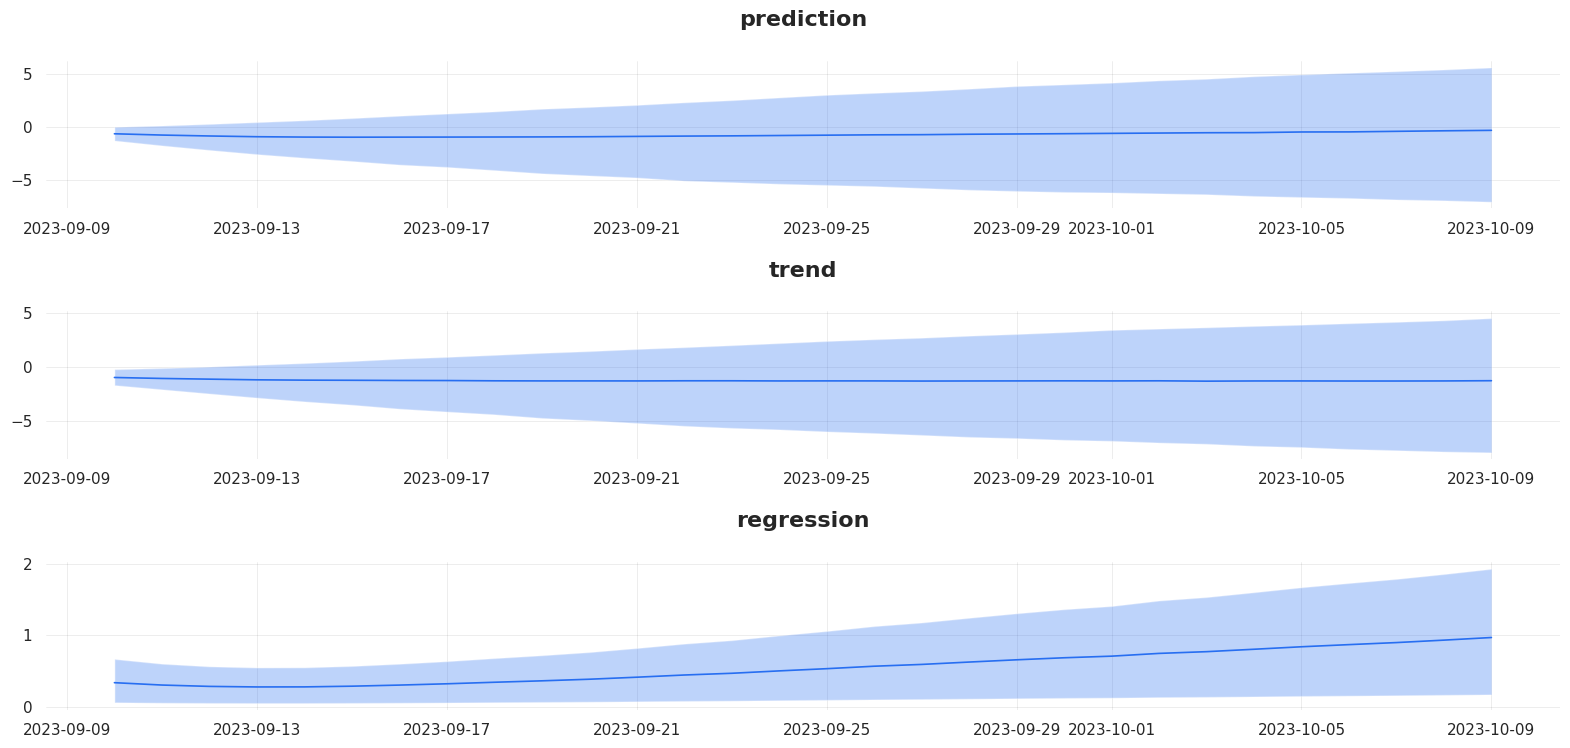

In [41]:
_ = plot_predicted_components(comps, "day", plot_components=['prediction', 'trend', 'regression'])

In [42]:
comps.head()

,day,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2023-09-10,-1.263413,-0.627005,0.028020,-1.689938,-0.976276,-0.203433,0.0,0.0,0.0,0.058730,0.335203,0.669139
1,2023-09-11,-1.728086,-0.748425,0.148263,-2.082567,-1.066838,-0.094059,0.0,0.0,0.0,0.052895,0.301899,0.602656
2,2023-09-12,-2.154390,-0.835132,0.301368,-2.473347,-1.131461,0.039934,0.0,0.0,0.0,0.049581,0.282985,0.564900
3,2023-09-13,-2.549812,-0.904344,0.474589,-2.854957,-1.193710,0.207812,0.0,0.0,0.0,0.048214,0.275182,0.549324
4,2023-09-14,-2.889691,-0.938494,0.645027,-3.207874,-1.223789,0.370643,0.0,0.0,0.0,0.048351,0.275966,0.550888


In [43]:
ps = model_list[5].get_posterior_samples(relabel=True, permute=False)
ps.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 'gt_sum', 'gb', 'gl', 'loglk', 'dau_stand', 'anomaly'])

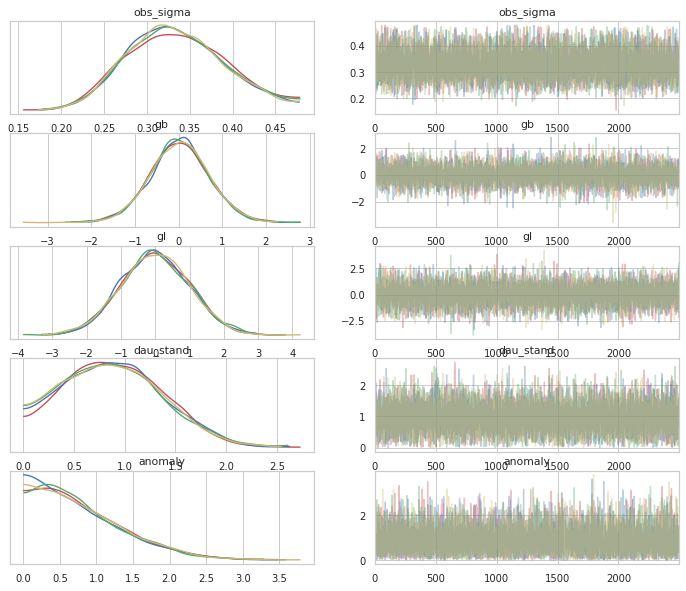

In [47]:
az.plot_trace(
    ps,
    var_names=['obs_sigma', 'gb', 'gl', 'dau_stand', 'anomaly'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
);

А теперь переведём предсказание в оригинальные единицы измерения:

In [48]:
pred_6[["prediction_5", "prediction", "prediction_95"]] = pred_6[["prediction_5", "prediction", "prediction_95"]] \
                         .apply(lambda x: (x * act_sd) + act_mean)

In [49]:
pred_6.head()

,day,prediction_5,prediction,prediction_95
0,2023-09-10,355388.374316,510519.534179,662115.723212
1,2023-09-11,269779.226002,491423.860636,712983.754526
2,2023-09-12,197121.748661,479748.498522,751658.341718
3,2023-09-13,138322.894714,474113.949700,800103.922319
4,2023-09-14,85580.025813,467905.729663,844951.385080


## Дополнительно: сравнение с реальными данными

Посмотрим, как оно было на самом деле:

In [52]:
test_data.head()

,day,dau,total_activity,anomaly,dau_stand,act_stand
0,2023-06-03,878,12389,0,-2.920635,-2.392554
1,2023-06-04,2238,88481,0,-2.642395,-2.120179
2,2023-06-05,3105,139381,0,-2.465017,-1.937979
3,2023-06-06,3721,155693,0,-2.338990,-1.879590
4,2023-06-07,4617,221856,0,-2.155679,-1.642756


In [53]:
(pred_1.prediction * act_sd) + act_mean

0     557147.055086
1     558570.947141
2     561514.932785
3     568802.229104
4     578074.425673
5     585014.701585
6     591368.426743
7     601134.486198
8     613039.063898
9     618832.151746
10    633734.911274
11    643678.682684
12    657589.243657
13    666802.604759
14    679575.416043
15    700802.362867
16    706072.595880
17    720983.130440
18    734920.818677
19    744638.118339
20    754570.763786
21    767124.691240
22    776434.766699
23    787652.287003
24    804398.904481
25    823090.433252
26    839002.529536
27    847955.326538
28    864386.307135
29    876315.051979
Name: prediction, dtype: float64

In [55]:
#добавим прогнозы

test_data["DAU_pred"] = (futur.dau_stand * dau_sd) + dau_mean
test_data["model1_pred"] = (pred_1.prediction * act_sd) + act_mean
test_data["model2_pred"] = (pred_2.prediction * act_sd) + act_mean
test_data["model3_pred"] = (pred_3.prediction * act_sd) + act_mean
test_data["model4_pred"] = (pred_4.prediction * act_sd) + act_mean
test_data["model5_pred"] = (pred_5.prediction * act_sd) + act_mean
test_data["model6_pred"] = pred_6.prediction

/tmp/ipykernel_1959/1525169791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["DAU_pred"] = (futur.dau_stand * dau_sd) + dau_mean
/tmp/ipykernel_1959/1525169791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["model1_pred"] = (pred_1.prediction * act_sd) + act_mean
/tmp/ipykernel_1959/1525169791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [56]:
test_data.head()

,day,dau,total_activity,anomaly,dau_stand,act_stand,DAU_pred,model1_pred,model2_pred,model3_pred,model4_pred,model5_pred,model6_pred
0,2023-06-03,878,12389,0,-2.920635,-2.392554,17047.147828,557147.055086,552040.496086,508412.738557,509124.335766,506249.786378,510519.534179
1,2023-06-04,2238,88481,0,-2.642395,-2.120179,16859.019369,558570.947141,546204.387812,491634.673959,491644.190600,490633.766779,491423.860636
2,2023-06-05,3105,139381,0,-2.465017,-1.937979,16752.180279,561514.932785,543463.899025,479099.599704,479012.416696,477276.766968,479748.498522
3,2023-06-06,3721,155693,0,-2.338990,-1.879590,16708.102672,568802.229104,537427.114369,471269.518204,472073.777712,471854.029893,474113.949700
4,2023-06-07,4617,221856,0,-2.155679,-1.642756,16712.529016,578074.425673,530811.635744,468056.669854,471320.489349,467539.653265,467905.729663


Посмотрим, насколько мы не угадали с DAU:

<Axes: >

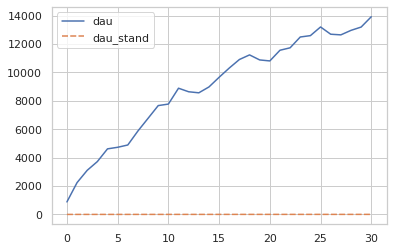

In [57]:
sns.lineplot(test_data.filter(regex=r"day|^dau"))

In [60]:
error_df = []

for pred_col in test_data.filter(regex=r"^model").columns:
    
    df = pd.DataFrame({"model":pred_col, 
                       "metric":["mae", "mse", "smape", "wmape"],
                       "value": [mae(test_data.total_activity, test_data[pred_col]), 
                                 mse(test_data.total_activity, test_data[pred_col]), 
                                 smape(test_data.total_activity, test_data[pred_col]), 
                                 wmape(test_data.total_activity, test_data[pred_col])]})
    error_df.append(df)
    
    

error_df = pd.concat(error_df)


In [61]:
for metric in error_df.metric.unique():
    
    winning_model = error_df.loc[error_df.metric == metric].set_index("model").value.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике mae - model2_pred
Самая лучшая модель по метрике mse - model4_pred
Самая лучшая модель по метрике smape - model2_pred
Самая лучшая модель по метрике wmape - model2_pred
